Problem 1
=========

In [2]:
def draw_arrow(ax, start, direction, color, scale_factor,label):
    ax.arrow(start[0], start[1], direction[0] * scale_factor, direction[1] * scale_factor, 
             color=color, head_width=0.5, head_length=0.5, linewidth=3)

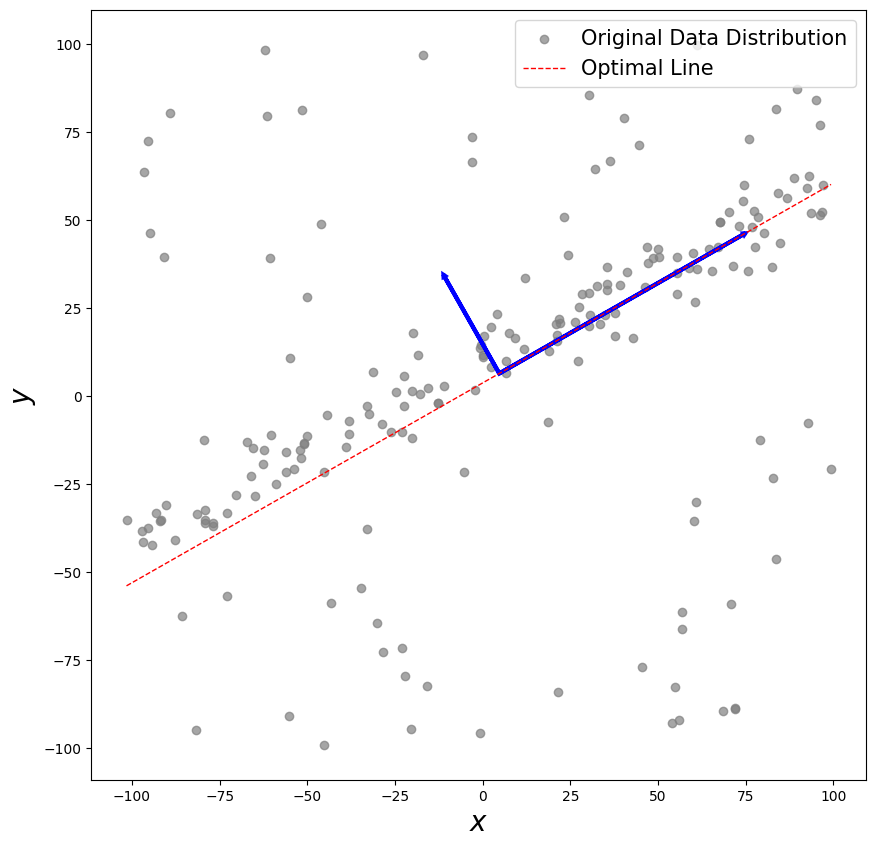

In [17]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# Load points
pts = scipy.io.loadmat("data_f_LSLF.mat")['pts']
x = pts[0]
y = pts[1]

# Visualize the data distribution
fig,ax = plt.subplots(figsize=(10, 10)) 
ax.scatter(x, y, marker='o', color='gray', alpha=0.7,label = "Original Data Distribution")
ax.set_xlabel("$x$", fontsize=20)
ax.set_ylabel("$y$", fontsize=20)

# Calculate the covariance matrix of data
C = np.cov(x, y)*len(pts[0])

# Find eigenvectors and eigenvalues of the covariance matrix
D, V = np.linalg.eig(C)
draw_arrow(ax, [np.mean(x), np.mean(y)], [V[0, 0], V[1, 0]], 'blue', D[0]/10000,label = "eigenvector")
draw_arrow(ax, [np.mean(x), np.mean(y)], [V[0, 1], V[1, 1]], 'blue', D[1]/10000,label = "eigenvector")

# Find the optimal line ax+by = d that fits the data in the total least squares sense.
# This requires finding the eigenvector corresponding to the smallest eigenvalue of C'*C.
U, S, _ = np.linalg.svd(np.dot(C.T, C))
d_opt = np.dot(U[:, -1], np.array([np.mean(x), np.mean(y)]))
normal_vector_opt = U[:, -1]
x_range = np.linspace(np.min(x), np.max(x), 100)
f = lambda x: (d_opt - normal_vector_opt[0] * x) / normal_vector_opt[1]
ax.plot(x_range, f(x_range), color='red', linewidth=1, linestyle='--',label = "Optimal Line")
ax.legend(fontsize = 15)
plt.show()


Problem 3
=========

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import imutils
from scipy.ndimage import gaussian_filter


In [6]:
def ssc(keypoints, num_ret_points, tolerance, cols, rows):
    '''
    Reference : https://github.com/BAILOOL/ANMS-Codes/tree/master/Python
    '''
    exp1 = rows + cols + 2 * num_ret_points
    exp2 = (
        4 * cols
        + 4 * num_ret_points
        + 4 * rows * num_ret_points
        + rows * rows
        + cols * cols
        - 2 * rows * cols
        + 4 * rows * cols * num_ret_points
    )
    exp3 = math.sqrt(exp2)
    exp4 = num_ret_points - 1

    sol1 = -round(float(exp1 + exp3) / exp4)  # first solution
    sol2 = -round(float(exp1 - exp3) / exp4)  # second solution

    high = (
        sol1 if (sol1 > sol2) else sol2
    )  # binary search range initialization with positive solution
    low = math.floor(math.sqrt(len(keypoints) / num_ret_points))

    prev_width = -1
    selected_keypoints = []
    result_list = []
    result = []
    complete = False
    k = num_ret_points
    k_min = round(k - (k * tolerance))
    k_max = round(k + (k * tolerance))

    while not complete:
        width = low + (high - low) / 2
        if (
            width == prev_width or low > high
        ):  # needed to reassure the same radius is not repeated again
            result_list = result  # return the keypoints from the previous iteration
            break

        c = width / 2  # initializing Grid
        num_cell_cols = int(math.floor(cols / c))
        num_cell_rows = int(math.floor(rows / c))
        covered_vec = [
            [False for _ in range(num_cell_cols + 1)] for _ in range(num_cell_rows + 1)
        ]
        result = []

        for i in range(len(keypoints)):
            row = int(
                math.floor(keypoints[i].pt[1] / c)
            )  # get position of the cell current point is located at
            col = int(math.floor(keypoints[i].pt[0] / c))
            if not covered_vec[row][col]:  # if the cell is not covered
                result.append(i)
                # get range which current radius is covering
                row_min = int(
                    (row - math.floor(width / c))
                    if ((row - math.floor(width / c)) >= 0)
                    else 0
                )
                row_max = int(
                    (row + math.floor(width / c))
                    if ((row + math.floor(width / c)) <= num_cell_rows)
                    else num_cell_rows
                )
                col_min = int(
                    (col - math.floor(width / c))
                    if ((col - math.floor(width / c)) >= 0)
                    else 0
                )
                col_max = int(
                    (col + math.floor(width / c))
                    if ((col + math.floor(width / c)) <= num_cell_cols)
                    else num_cell_cols
                )
                for row_to_cover in range(row_min, row_max + 1):
                    for col_to_cover in range(col_min, col_max + 1):
                        if not covered_vec[row_to_cover][col_to_cover]:
                            # cover cells within the square bounding box with width w
                            covered_vec[row_to_cover][col_to_cover] = True

        if k_min <= len(result) <= k_max:  # solution found
            result_list = result
            complete = True
        elif len(result) < k_min:
            high = width - 1  # update binary search range
        else:
            low = width + 1
        prev_width = width

    for i in range(len(result_list)):
        selected_keypoints.append(keypoints[result_list[i]])

    return selected_keypoints

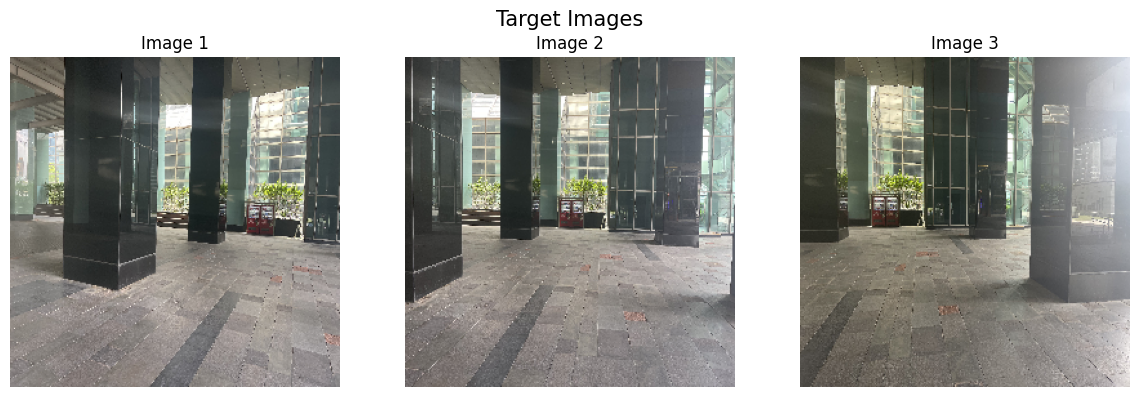

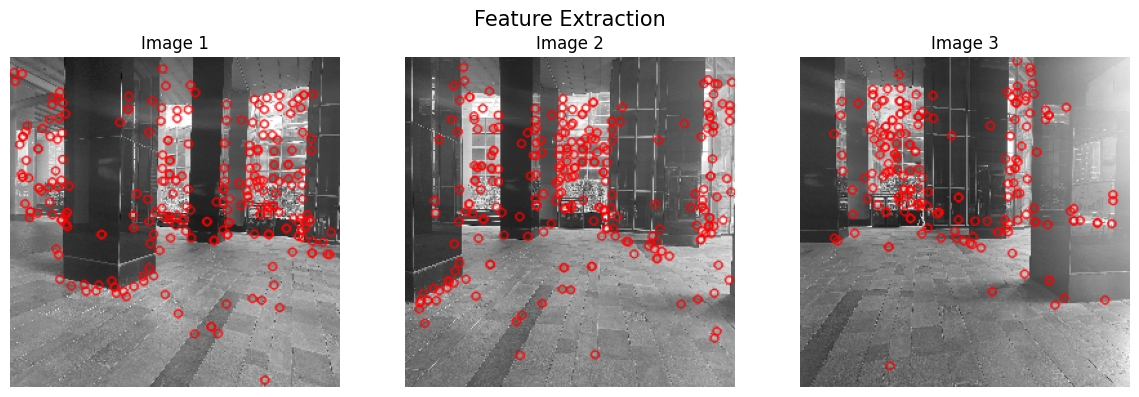

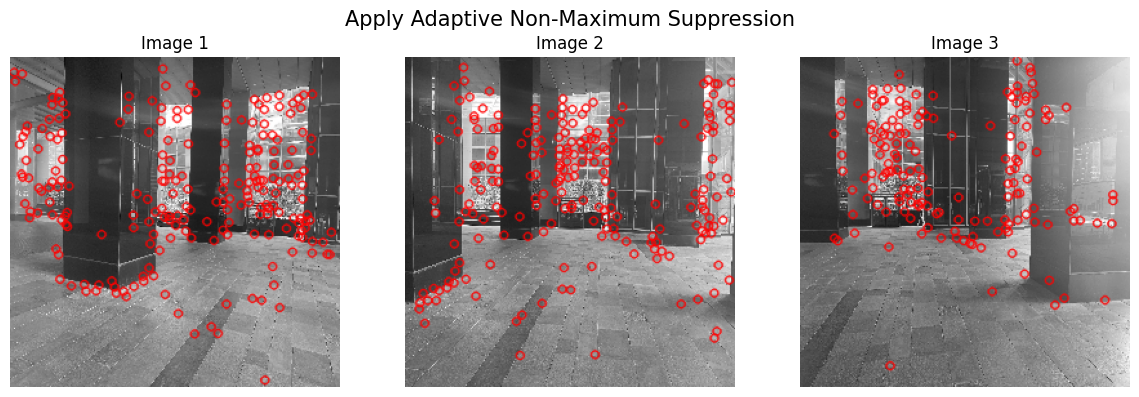

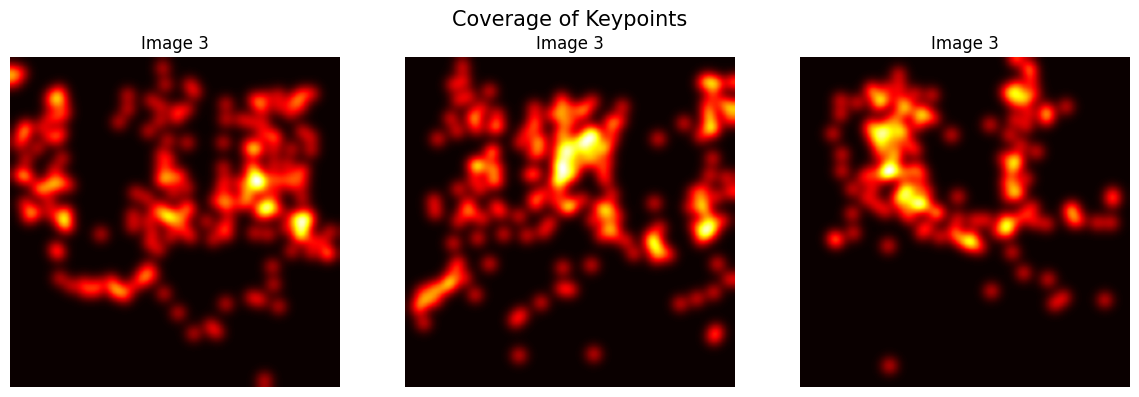

In [7]:
# load images
I1_path = "../hw3/I1.jpg"
I2_path = "../hw3/I2.jpg"
I3_path = "../hw3/I3.jpg"

I1 = cv2.imread(I1_path,0)
I2 = cv2.imread(I2_path,0)
I3 = cv2.imread(I3_path,0)

I1_color = cv2.imread(I1_path)
I2_color = cv2.imread(I2_path)
I3_color = cv2.imread(I3_path)

# preprocessing the images
I1 = cv2.resize(I1,[256,256])
I2 = cv2.resize(I2,[256,256])
I3 = cv2.resize(I3,[256,256])

I1_color = cv2.resize(I1_color,[256,256])
I2_color = cv2.resize(I2_color,[256,256])
I3_color = cv2.resize(I3_color,[256,256])

fig, axs = plt.subplots(1,3,figsize = (12,4))
axs[0].imshow(cv2.cvtColor(I1_color,cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(I2_color,cv2.COLOR_BGR2RGB))
axs[2].imshow(cv2.cvtColor(I3_color,cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title("Image 1")
axs[1].axis('off')
axs[1].set_title("Image 2")
axs[2].axis('off')
axs[2].set_title("Image 3")
fig.suptitle("Target Images",fontsize=15)
fig.tight_layout()

sift = cv2.SIFT_create()
kp1 = sift.detect(I1,None)
kp2 = sift.detect(I2,None)
kp3 = sift.detect(I3,None)

fig, axs = plt.subplots(1,3,figsize = (12,4))
axs[0].imshow(cv2.drawKeypoints(I1, kp1, I1,color = [255,0,0]))
axs[1].imshow(cv2.drawKeypoints(I2, kp2, I2,color = [255,0,0]))
axs[2].imshow(cv2.drawKeypoints(I3, kp3, I3,color = [255,0,0]))
axs[0].axis('off')
axs[0].set_title("Image 1")
axs[1].axis('off')
axs[1].set_title("Image 2")
axs[2].axis('off')
axs[2].set_title("Image 3")
fig.suptitle("Feature Extraction",fontsize=15)
fig.tight_layout()


kp1 = sorted(kp1, key =lambda x : x.response, reverse = True)
kp1_anms = ssc(kp1, 250, 0.2, I1.shape[1], I1. shape[0])
kp2= sorted(kp2, key =lambda x : x.response, reverse = True)
kp2_anms = ssc(kp2, 250, 0.2, I2.shape[1], I2. shape[0])
kp3 = sorted(kp3, key =lambda x : x.response, reverse = True)
kp3_anms = ssc(kp3, 250, 0.2, I3.shape[1], I3. shape[0])

_,des1 = sift.compute(I1,kp1_anms)
_,des2 = sift.compute(I2,kp2_anms)
_,des3 = sift.compute(I3,kp3_anms)

fig, axs = plt.subplots(1,3,figsize = (12,4))
axs[0].imshow(cv2.drawKeypoints(I1, kp1_anms, I1,color = [255,0,0]))
axs[1].imshow(cv2.drawKeypoints(I2, kp2_anms, I2,color = [255,0,0]))
axs[2].imshow(cv2.drawKeypoints(I3, kp3_anms, I3,color = [255,0,0]))
axs[0].axis('off')
axs[0].set_title("Image 1")
axs[1].axis('off')
axs[1].set_title("Image 2")
axs[2].axis('off')
axs[2].set_title("Image 3")
fig.suptitle("Apply Adaptive Non-Maximum Suppression",fontsize=15)
fig.tight_layout()

fig, axs = plt.subplots(1,3,figsize = (12,4))
coverage = np.zeros_like(I1, dtype=np.float64)

for keypoint in kp1_anms:
    x, y = keypoint.pt
    coverage[int(y), int(x)] = 1

coverage = gaussian_filter(coverage, sigma=5)
axs[0].imshow(coverage,cmap = 'hot')
axs[0].set_title("Image 3")
axs[0].axis('off')

coverage = np.zeros_like(I2, dtype=np.float64)

for keypoint in kp2_anms:
    x, y = keypoint.pt
    coverage[int(y), int(x)] = 1

coverage = gaussian_filter(coverage, sigma=5)
axs[1].imshow(coverage,cmap = 'hot')
axs[1].set_title("Image 3")
axs[1].axis('off')

coverage = np.zeros_like(I3, dtype=np.float64)

for keypoint in kp3_anms:
    x, y = keypoint.pt
    coverage[int(y), int(x)] = 1

coverage = gaussian_filter(coverage, sigma=5)
axs[2].imshow(coverage,cmap = 'hot')
axs[2].set_title("Image 3")
axs[2].axis('off')
fig.suptitle("Coverage of Keypoints",fontsize=15)
fig.tight_layout()

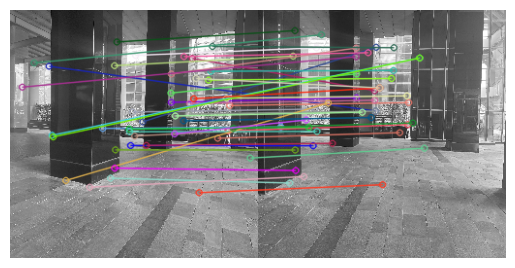

In [15]:
# Convert descriptors to CV_8U data type if necessary
des1 = des1.astype(np.uint8)
des2 = des2.astype(np.uint8)

# Create BFMatcher
bf = cv2.BFMatcher()
_matches = bf.knnMatch(des1,des2,k=2)

matches = []

for m,n in _matches : 
    if m.distance < 0.8*n.distance:
        matches.append([m])

# Draw first 10 matches
img3 = cv2.drawMatchesKnn(I1, kp1_anms, I2, kp2_anms, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display image
plt.imshow(img3)
plt.axis('off')
plt.show()


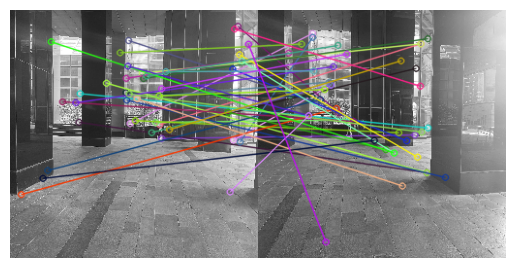

In [16]:
# Convert descriptors to CV_8U data type if necessary
des2 = des2.astype(np.uint8)
des3 = des3.astype(np.uint8)

# Create BFMatcher
bf = cv2.BFMatcher()
_matches = bf.knnMatch(des1,des2,k=2)

matches = []

for m,n in _matches : 
    if m.distance < 0.8*n.distance:
        matches.append([m])

# Draw first 10 matches
img3 = cv2.drawMatchesKnn(I2, kp2, I3, kp3, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display image
plt.imshow(img3)
plt.axis('off')
plt.show()


In [17]:
def DLT(matches,kp1,kp2):
    '''
    Homography estimation by using DLT
    matches : cv2.DMatch
    '''
    assert len(matches)>3
    A = construct_A(matches,kp1,kp2)
    _,_,V = np.linalg.svd(A)
    return V[-1].reshape(3,3)/V[-1][-1]

def contruct_A_partial(match,kp1,kp2):
    if isinstance(match,cv2.DMatch):
        p1 = kp1[match.queryIdx].pt
        p2 = kp2[match.trainIdx].pt
    else:
        p1 = match[:2]
        p2 = match[2:]
    return np.array([
        [0, 0, 0, -p1[0], -p1[1], -1, p2[1]*p1[0], p2[1]*p1[1], p2[1]*1],
        [p1[0], p1[1],1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]]
                     ])

def construct_A(matches, kp1,kp2):
    output = []
    for match in matches:
        output.append(contruct_A_partial(match,kp1,kp2))
    return np.vstack(output)

H_12 :  [[ 1.75851228e+00  4.83310308e-02 -1.47635707e+02]
 [ 2.77217109e-01  1.45647680e+00 -5.08731731e+01]
 [ 2.80065842e-03  1.35878837e-05  9.97068339e-01]]
Symmetric transfer error of H_12 :  534818.6942181435
H_32 :  [[ 4.22939925e-01 -2.71477408e-02  2.25430247e+02]
 [-2.21725216e-01  8.54010577e-01  6.81337676e+01]
 [-1.43509611e-03 -1.59134790e-05  1.00142383e+00]]
Symmetric transfer error of H_32 :  970885.0502085695


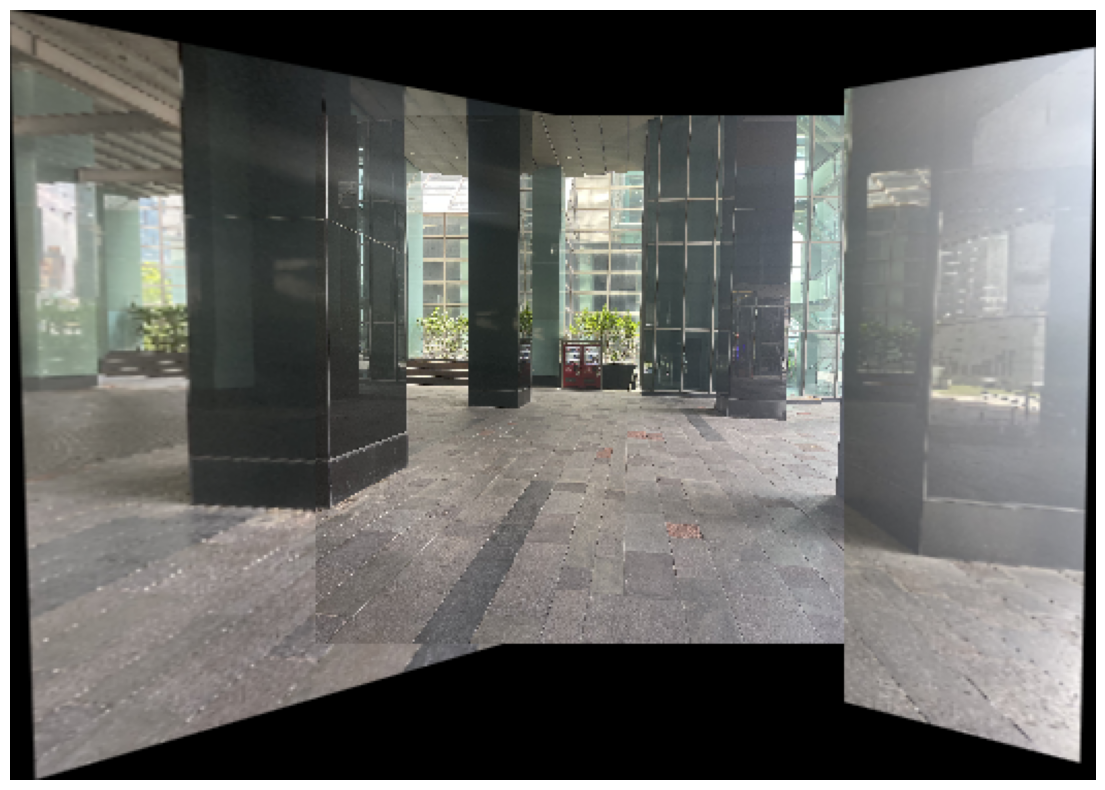

In [21]:
t = 1.25
p = 0.99
from scipy.optimize import least_squares

def getCorrespondance(matches,kp1,kp2):
    '''
    Convert cv2.DMatch type into [x1,y1,x2,y2] python list
    '''
    correspondance = []
    for match in matches:
        correspondance.append([kp1[match.queryIdx].pt[0],kp1[match.queryIdx].pt[1],kp2[match.trainIdx].pt[0],kp2[match.trainIdx].pt[1]])
    return correspondance

def get_distance(corr, h):
    '''
    distance measure : symmetric transfer error
    d = d(x, H^{-1}x')^2 + d(x', Hx)^2
    '''    
    p1 = corr[:2]
    p2 = corr[2:]
    p1 = np.append(p1,1)
    p2 = np.append(p2,1)
    p2_est = np.dot(h,p1)
    p2_est /=p2_est[2]
    p1_est = np.dot(np.linalg.inv(h),p2)
    p1_est /= p1_est[2]

    return np.linalg.norm(p1-p1_est,ord = 2)**2 + np.linalg.norm(p2-p2_est,ord = 2)**2


def _ransac(matches, kp1,kp2,N):
    '''
    Compute Homography between two images
    '''
    corr = getCorrespondance(matches, kp1,kp2)
    max_inliers = []
    final_h = None
    for _ in range(N):
        idxs = np.random.permutation(range(0,len(matches)))
        partial_mathces = [matches[i] for i in idxs[:4]]
        h = DLT(partial_mathces,kp1,kp2)

        inliers = []

        for i in range(len(corr)):
            d = get_distance(corr[i], h)
            if d<t:
                inliers.append(corr[i])
        if len(inliers)>len(max_inliers):
            max_inliers = inliers
            final_h = h

    return final_h, max_inliers


def accumulate_error(h, points):
    '''
    Squared sum of error
    '''
    result = []
    h = h.reshape((3,3))
    for i in range(len(points)):
        d = get_distance(points[i], h)
        result.extend([d])
    return result

def optimal_h_estimate(max_inliers,h):
    inliers = np.vstack(max_inliers)
    h_init = h
    res = least_squares(accumulate_error, h_init.flatten(), args=(inliers,))
    h_opt = res.x.reshape((3, 3))
    return h_opt

def guided_matching(h, kp1, kp2, matches,threshold):
    new_matches = []
    for match in matches:
        # Project kp1 to kp2 with homography
        p1 = kp1[match.queryIdx].pt
        p2 = kp2[match.trainIdx].pt
        p2_pred = np.dot(h,np.append(p1,1))
        p2_pred /= p2_pred[2]

        if np.linalg.norm(p2_pred - np.append(p2,1)) < threshold:
            new_matches.append(match)
    return new_matches

def ransac(matches, kp1, kp2,N):
    h, inliers = _ransac(matches, kp1, kp2,N)
    while True:
        # Step (iv): re-estimate H from all inliers by minimizing ML cost function
        h_opt = optimal_h_estimate(inliers,h)
        # Step (v): Determine more matches using prediction by computed H
        new_matches = guided_matching(h_opt, kp1, kp2, matches,t)
        # If no more new matches, break
        if len(new_matches) == len(matches):
            break
        matches = new_matches
    return h_opt, matches

def sample_num_adaptive(matches, kp1, kp2, s=4, p=0.99):
    '''
    Estimation of Sample number in RANSAC
    '''
    N = float('inf')
    sample_count = 0
    corr = getCorrespondance(matches,kp1,kp2)
    while N > sample_count:
        # randomly select s points
        idxs = np.random.permutation(range(0,len(matches)))
        partial_matches = [matches[i] for i in idxs[:s]]
        h = DLT(partial_matches, kp1, kp2)
        inliers = []

        for i in range(len(corr)):
            d = get_distance(corr[i], h)
            if d<t:
                inliers.append(corr[i])

        # update epsilon
        eps = 1 - len(inliers) / len(matches)
        N = np.log(1 - p) / np.log(1 - (1 - eps) ** s)
        sample_count += 1
    return N


def mosaic_images(I1, I2, H,alpha = 0.5):
    mosaic = cv2.warpPerspective(I1, H, (I2.shape[1], I2.shape[0]))
    return cv2.addWeighted(mosaic, alpha, I2, 1 - alpha, 0)

def warp_images(image1, image2, H):
    # Get the shape of the two images
    rows1, cols1 = image1.shape[:2]
    rows2, cols2 = image2.shape[:2]

    # Get the corners of the images
    list_of_points1 = np.float32([[0,0], [0,rows1], [cols1, rows1], [cols1,0]]).reshape(-1, 1, 2)
    temp_points = np.float32([[0,0], [0,rows2], [cols2, rows2], [cols2,0]]).reshape(-1, 1, 2)

    # When we have established a homography we need to warp perspective
    # Change field of view
    list_of_points2 = cv2.perspectiveTransform(temp_points, H)

    # Find max and min points to create new image dimensions
    all_points = np.concatenate((list_of_points1, list_of_points2), axis=0)
    [x_min, y_min] = np.int32(all_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_points.max(axis=0).ravel() + 0.5)

    # Translate homography to account for negative values
    translation_dist = [-x_min, -y_min]
    H_translate = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    # Warp the second image and merge with the first image
    warped_image2 = cv2.warpPerspective(image2, H_translate.dot(H), (x_max - x_min, y_max - y_min))
    warped_image2[translation_dist[1]:rows1 + translation_dist[1], translation_dist[0]:cols1 + translation_dist[0]] = image1

    return warped_image2

def crop_images(stitched):
    stitched = cv2.copyMakeBorder(stitched, 10, 10, 10, 10,
			cv2.BORDER_CONSTANT, (0, 0, 0))
    gray = cv2.cvtColor(stitched, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
			cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # allocate memory for the mask which will contain the
    # rectangular bounding box of the stitched image region
    mask = np.zeros(thresh.shape, dtype="uint8")
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

    minRect = mask.copy()
    sub = mask.copy()
    # keep looping until there are no non-zero pixels left in the
    # subtracted image
    while cv2.countNonZero(sub) > 0:
        # erode the minimum rectangular mask and then subtract
        # the thresholded image from the minimum rectangular mask
        # so we can count if there are any non-zero pixels left
        minRect = cv2.erode(minRect, None)
        sub = cv2.subtract(minRect, thresh)

    cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL,
			cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    (x, y, w, h) = cv2.boundingRect(c)
    # use the bounding box coordinates to extract the our final
    # stitched image
    stitched = stitched[y:y + h, x:x + w]
    return stitched


def main(verbose = False, crop = True):
    I1_path = "../hw3/I1.jpg"
    I2_path = "../hw3/I2.jpg"
    I3_path = "../hw3/I3.jpg"

    I1_color = cv2.imread(I1_path)
    I2_color = cv2.imread(I2_path)
    I3_color = cv2.imread(I3_path)

    I1_color = cv2.resize(I1_color,[256,256])
    I2_color = cv2.resize(I2_color,[256,256])
    I3_color = cv2.resize(I3_color,[256,256])

    I1 = cv2.cvtColor(I1_color,cv2.COLOR_BGR2GRAY)
    I2 = cv2.cvtColor(I2_color,cv2.COLOR_BGR2GRAY)
    I3 = cv2.cvtColor(I3_color,cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(I1,None)
    kp2, des2 = sift.detectAndCompute(I2,None)

    des1 = des1.astype(np.uint8)
    des2 = des2.astype(np.uint8)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    N = int(sample_num_adaptive(matches, kp1, kp2))
    H_12,_ = ransac(matches, kp1, kp2, N)
    print("H_12 : ", H_12)
    corr = getCorrespondance(matches, kp1, kp2)
    print("Symmetric transfer error of H_12 : ",sum([get_distance(corr[i], H_12) for i in range(len(matches))]))

    # Stitch I2 and I1
    stitched_12 = warp_images(I2_color, I1_color, H_12)

    # Convert stitched image to grayscale and compute keypoints and descriptors
    stitched_12_gray = cv2.cvtColor(stitched_12, cv2.COLOR_BGR2GRAY)
    kp_stitched_12, des_stitched_12 = sift.detectAndCompute(stitched_12_gray, None)
    kp3, des3 = sift.detectAndCompute(I3,None)

    des_stitched_12 = des_stitched_12.astype(np.uint8)
    des3 = des3.astype(np.uint8)    


    # Match descriptors between stitched image of I1 and I2 with I3
    matches = bf.match(des3, des_stitched_12)
    matches = sorted(matches, key=lambda x: x.distance)

    N = int(sample_num_adaptive(matches, kp3, kp_stitched_12))
    H_stitched_123,_ = ransac(matches, kp3, kp_stitched_12, N)

    print("H_32 : ", H_stitched_123)
    corr = getCorrespondance(matches, kp3,kp_stitched_12)
    print("Symmetric transfer error of H_32 : ",sum([get_distance(corr[i], H_stitched_123) for i in range(len(matches))]))

    # Stitch I3 and the stitched image of I1 and I2
    # final_mosaic = crop_images(warp_images(stitched_12, I3_color, H_stitched_123))
    final_mosaic = warp_images(stitched_12, I3_color, H_stitched_123)
    if crop:
        final_mosaic = crop_images(final_mosaic)

    if verbose:
        plt.subplots(1,1,figsize = (20,10))
        cv2.namedWindow('mosaic', cv2.WINDOW_NORMAL)
        plt.imshow(cv2.cvtColor(final_mosaic,cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


if __name__ == "__main__":
    main(True,False)